In [1]:
import numpy as np 
import json
import sys, os
import getopt

In [2]:
def parseJson(filename):
    # Try to load the json file
    try:
        with open(filename) as f:
            jsonData = json.load(f)

    except:
        sys.stderr.write("Unable to open file '%s'" % filename)
        return
    
    # The json file contains game_states, player_input, messages, and ui_events
    gameStatesJson = jsonData['game_states']
    
    # Parse the game states
    frames, missiles, shells = parseGameStates(gameStatesJson)

    # Collate all the data into a dictionary
    gameData = { 'frames': frames,
                'missiles': missiles,
                'shells': shells}
    return gameData

In [3]:
def parseGameStates(gameStates, fortress_ids = ['0'], player_ids = ['0','1']):
	"""
	Convert a json representation of the game states to three numpy arrays:
	frames - tickNum, time, score, pose of fortresses, players, and border
	missiles - tickNum, id, and pose of each missile
	shells - tickNum, id, and pose of each shell
	"""

	# Keep as list of frame, missile and shell data extracted from each frame
	frames, missiles, shells = [], [], []

	for state in gameStates:
		_frame, _missiles, _shells = parseGameFrame(state, fortress_ids, player_ids)
		frames.append(_frame)
		missiles.append(_missiles)
		shells.append(_shells)

	# Convert the list to 2D numpy arrays
	frames = np.vstack(frames)
	missiles = np.vstack(missiles)
	shells = np.vstack(shells)

	return frames, missiles, shells

In [4]:
def parseGameFrame(frame, fortress_ids = ['0'], player_ids = ['0','1']):
	"""
	Convert a json representation of a single game frame to a npy representation
	"""

	## Game data and objects - can be put in a single line in a np array

	# Frame-level data (e.g., tick number, time, etc)
	tickNum = frame['tick']
	time = frame['time']
	score = frame['score']
	frame_gamedata = np.array([tickNum, time, score])

	# Get the fortress and player states
	fortresses = [parseFortress(frame['fortresses'][_id]) for _id in fortress_ids]
	players = [parsePlayer(frame['players'][_id]) for _id in player_ids]
	border = np.array([frame['border'][pos] for pos in ['xMin', 'xMax', 'yMin', 'yMax']])

	# Concatenate everything to a flat representation
	frame_data = np.concatenate([frame_gamedata] + fortresses + players + [border])

	missiles = []
	shells = []

	## Missile and shells
	if frame['missiles'] is not None:
		_missiles = frame['missiles']
		missiles = [np.concatenate([np.array([tickNum, int(_id)]), parseProjectile(_missiles[_id])]) for _id in _missiles.keys()]

	if frame['shells'] is not None:
		_shells = frame['shells']
		shells = [np.concatenate([np.array([tickNum, int(_id)]), parseProjectile(_shells[_id])]) for _id in _shells.keys()]

	# Convert shells and missiles to np arrays, possibly with 0 elements
	missiles = np.reshape(np.array(missiles), (-1,5))
	shells = np.reshape(np.array(shells), (-1,5))

	return frame_data, missiles, shells

In [5]:
def parsePlayer(player):
	"""
	Convert player data from json to numpy format

	Array index to value:
		0	x
		1	y
		2	angle
		3	vx
		4	vy
		5	alive
	"""

	player_npy = np.zeros((6,), dtype=np.float32)

	player_npy[0] = player['position']['x']
	player_npy[1] = player['position']['y']
	player_npy[2] = player['angle']
	player_npy[3] = player['velocity']['x']
	player_npy[4] = player['velocity']['y']
	player_npy[5] = 1.0 if player['alive'] else 0.0

	return player_npy

In [6]:
def parseFortress(fortress):
	"""
	Convert fortress data from json to numpy format 

	Array index to value:
		0	x
		1	y
		2	angle
		3	alive
		4	target_id
		5	vulnerable
		6	shield x
		7	shield y
		8	shield angle
		9	shield radius
		10	activation region x
		11	activation region y
		12	activation region angle
		13	activation region radius
	"""

	fortress_npy = np.zeros((14,), dtype=np.float32)

	# Fortress Data
	fortress_npy[0] = fortress['x']
	fortress_npy[1] = fortress['y']
	fortress_npy[2] = fortress['angle']
	fortress_npy[3] = 1.0 if fortress['alive'] else 0.0
	fortress_npy[4] = fortress['target']

	# Shield Data
	fortress_npy[5] = 1.0 if fortress['shield']['vulnerable'] else 0.0
	fortress_npy[6] = fortress['shield']['position']['x']
	fortress_npy[7] = fortress['shield']['position']['y']
	fortress_npy[8] = fortress['shield']['angle']
	fortress_npy[9] = fortress['shield']['radius']

	# Activation Region Data
	fortress_npy[10] = fortress['activationRegion']['position']['x']
	fortress_npy[11] = fortress['activationRegion']['position']['y']
	fortress_npy[12] = fortress['activationRegion']['angle']
	fortress_npy[13] = fortress['activationRegion']['radius']

	return fortress_npy

In [7]:
def parseProjectile(projectile):
	"""
	Convert shell json data to numpy format

	Array index to value
		0	x
		1	y
		2	angle
	"""

	projectile_npy = np.zeros((3,), dtype=np.float32)

	projectile_npy[0] = projectile['position']['x']
	projectile_npy[1] = projectile['position']['y']
	projectile_npy[2] = projectile['angle']

	return projectile_npy

In [8]:
input_path = 'data/tsf_data_shooterID-zhl136_baitID-sap187_run-9_361727.json'
game_data = parseJson(input_path)

In [9]:
game_data['frames'].shape

(5400, 33)

the video is 30 fps,so 10 min is 300 ticks

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

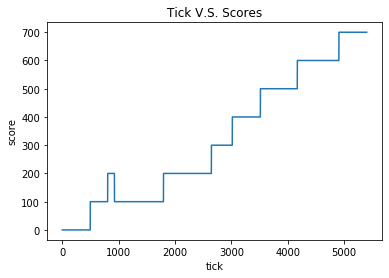

In [11]:
tick = game_data['frames'][:,0]
time = game_data['frames'][:,1]
scores = game_data['frames'][:,2]
plt.plot(tick,scores)
plt.title("Tick V.S. Scores")
plt.xlabel("tick")
plt.ylabel("score")
plt.show()

In [12]:
# detect the important event
event_tick = []
alive = True
for frame in game_data['frames']:
    if frame[6] == 0 and alive == True:
        alive = False
        event_tick.append(int(frame[0]))
    elif frame[6] == 1 and alive == False:
        alive = True
print(event_tick)

[496, 805, 1795, 2645, 3016, 3514, 4169, 4907]


In [13]:
# parameters setting
clip_max_len = 300
clip_min_len = 150
clip_ticks = []



# generate clips
for event in event_tick:
    start = event - clip_max_len
    interest_start = start
    for frame in game_data['frames'][event:start:-1]:
        if frame[8] == 0 or frame[22] == 0 or frame[28] == 0:
            interest_start = int(frame[0])
            break
    if event - interest_start > clip_min_len:
        clip_ticks.append((interest_start,event))
        
print(clip_ticks)

[(337, 496), (1495, 1795), (2345, 2645), (3869, 4169)]


In [14]:
def convert_to_range_bearing(player_pos, fortress_angle):
	"""
	"""

	distance = np.sqrt(player_pos[:,0]**2 + player_pos[:,1]**2)
	player_angle = np.arctan2(player_pos[:,1], player_pos[:,0])*180./np.pi

	angle_relative_to_fortress = (player_angle - fortress_angle)
	angle_relative_to_fortress = ((angle_relative_to_fortress + 180) % 360) - 180

	return distance, angle_relative_to_fortress

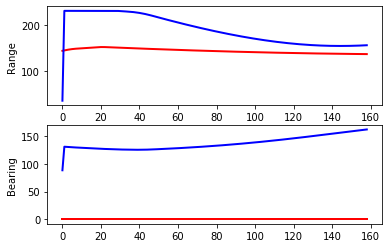

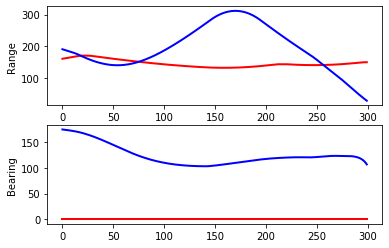

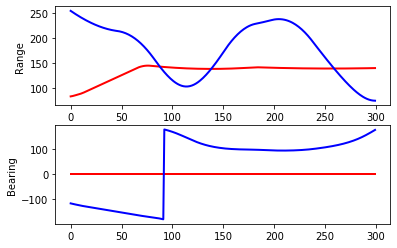

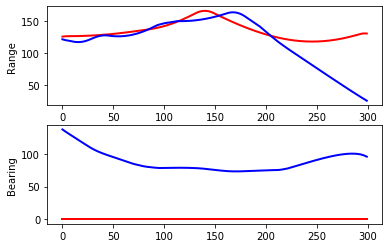

In [15]:
# plot the trajectry
for clip_start,clip_end in clip_ticks:
    clip = game_data['frames'][clip_start:clip_end]
    fortress_angle = clip[:,5]

    player0pos = clip[:,[17,18]]
    player1pos = clip[:,[23,24]]
    
    # Get the range and bearing (relative to fortress) of each player
    player0_range, player0_bearing = convert_to_range_bearing(player0pos, fortress_angle)
    player1_range, player1_bearing = convert_to_range_bearing(player1pos, fortress_angle)
    
    # Plot these
    plt.subplot(211)

    plt.plot(player0_range, '-r', linewidth=2)
    plt.plot(player1_range, '-b', linewidth=2)
    plt.ylabel('Range')

    plt.subplot(212)

    plt.plot(player0_bearing, '-r', linewidth=2)
    plt.plot(player1_bearing, '-b', linewidth=2)
    plt.ylabel('Bearing')
    
    plt.show()


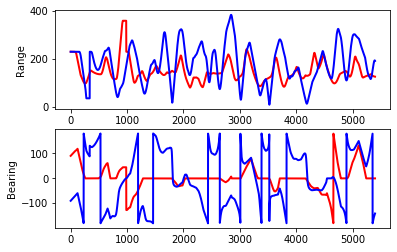

In [16]:
    clip = game_data['frames']
    fortress_angle = clip[:,5]

    player0pos = clip[:,[17,18]]
    player1pos = clip[:,[23,24]]
    
    # Get the range and bearing (relative to fortress) of each player
    player0_range, player0_bearing = convert_to_range_bearing(player0pos, fortress_angle)
    player1_range, player1_bearing = convert_to_range_bearing(player1pos, fortress_angle)
    
    # Plot these
    plt.subplot(211)

    plt.plot(player0_range, '-r', linewidth=2)
    plt.plot(player1_range, '-b', linewidth=2)
    plt.ylabel('Range')

    plt.subplot(212)

    plt.plot(player0_bearing, '-r', linewidth=2)
    plt.plot(player1_bearing, '-b', linewidth=2)
    plt.ylabel('Bearing')
    
    plt.show()